# Title

https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202

## Environment

In [0]:
#some dtype problem that came out only in 0.23 for get_dummies
!pip3 install --upgrade pandas

In [0]:
from google.colab import files

In [0]:
foo = files.upload()
foo = None

Saving kaggle.json to kaggle.json


In [0]:
!chmod 600 kaggle.json

In [0]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c 20-newsgroups-ciphertext-challenge

  0% 0.00/556k [00:00<?, ?B/s]
100% 556k/556k [00:00<00:00, 35.9MB/s]
 56% 9.00M/16.2M [00:00<00:00, 13.8MB/s]
100% 16.2M/16.2M [00:00<00:00, 23.7MB/s]
 72% 5.00M/6.98M [00:00<00:00, 16.6MB/s]
100% 6.98M/6.98M [00:00<00:00, 20.0MB/s]


In [0]:
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
!rm /root/.kaggle/kaggle.json

In [0]:
!ls

sample_data		   test.csv	 train.csv
sample_submission.csv.zip  test.csv.zip  train.csv.zip


## Model

In [0]:
import pandas as pd
import numpy as np

In [0]:
import keras.layers as KL
from keras.models import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2

Using TensorFlow backend.


In [0]:
input_tensor = KL.Input((300,128,1), name='input_tensor')
triple_tensor = KL.Concatenate(name='triple_tensor')([input_tensor, input_tensor, input_tensor])

input_diff = KL.Input((4,), name='input_diff')

In [0]:
inception_model = InceptionResNetV2(include_top=False,
                      weights='imagenet',
                      input_tensor=None,
                      input_shape=(300, 128, 3),
                      pooling='avg',
                      classes=20)(triple_tensor)
#classes arg probably not needed
#pooling based on default if top was included, don't know if avg is good

In [0]:
x = KL.Dropout(rate=0.2, name='drop0')(inception_model)
x = KL.Concatenate(name='concat0')([x, input_diff])
x = KL.Dense(20, activation='relu', name='dense0')(x)
x = KL.Dropout(rate=0.2, name='drop1')(x)
prediction = KL.Dense(20, activation='softmax', name='predictions')(x)
model = Model(inputs=[input_tensor, input_diff], outputs=[prediction])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tensor (InputLayer)       (None, 300, 128, 1)  0                                            
__________________________________________________________________________________________________
triple_tensor (Concatenate)     (None, 300, 128, 3)  0           input_tensor[0][0]               
                                                                 input_tensor[0][0]               
                                                                 input_tensor[0][0]               
__________________________________________________________________________________________________
inception_resnet_v2 (Model)     (None, 1536)         54336736    triple_tensor[0][0]              
__________________________________________________________________________________________________
drop0 (Dro

import weights (if desired)

In [0]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [0]:
import io
from googleapiclient.http import MediaIoBaseDownload

In [0]:
file_id = '11jNGQbMpO5zBR2NS_Lnd8wL24QeOhRg2'
request = drive_service.files().get_media(fileId=file_id)
#fh = io.BytesIO()
fh = io.FileIO('first_weights.h5', mode='w')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()

In [0]:
model.load_weights('logs/weights.02-3.00.hdf5', by_name=True)

sanity check start

In [0]:
!ls -l

In [0]:
!rm test.h5

In [0]:
!cat adc.json

In [0]:
model.load_weights('first_weights.h5')#, by_name=True)

In [0]:
model.save_weights('test.h5')

In [0]:
model.load_weights('test.h5')

sanity check end

In [0]:
import re

In [0]:
class SetTrainable(object):

  def __init__(self, model):
    self.keras_model = model

  def set_trainable(self, layer_regex, keras_model=None, indent=0, verbose=1):
    """Sets model layers as trainable if their names match
    the given regular expression.
    """
    # Print message on the first call (but not on recursive calls)
    if verbose > 0 and keras_model is None:
      print("Selecting layers to train")

    keras_model = keras_model or self.keras_model

    # In multi-GPU training, we wrap the model. Get layers
    # of the inner model because they have the weights.
    layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
      else keras_model.layers

    for layer in layers:
      # Is the layer a model?
      if layer.__class__.__name__ == 'Model':
        print("In model: ", layer.name)
        self.set_trainable(
            layer_regex, keras_model=layer, indent=indent + 4)
        continue

      if not layer.weights:
        continue
      # Is it trainable?
      trainable = bool(re.fullmatch(layer_regex, layer.name))
      # Update layer. If layer is a container, update inner layer.
      if layer.__class__.__name__ == 'TimeDistributed':
        layer.layer.trainable = trainable
      else:
        layer.trainable = trainable
      # Print trainable layer names
      if trainable and verbose > 0:
        print("{}{:20}   ({})".format(" " * indent, layer.name,
                                    layer.__class__.__name__))

incorrect output:

In [0]:
foo = SetTrainable(model)
foo.set_trainable(r'(predictions)|(dense0)|(conv2d_20\d)|(block8_10_conv)|(conv_7b)')
foo = None

Selecting layers to train
In model:  inception_resnet_v2
    conv2d_204             (Conv2D)
    conv2d_205             (Conv2D)
    conv2d_206             (Conv2D)
    conv2d_207             (Conv2D)
    conv2d_208             (Conv2D)
    conv2d_209             (Conv2D)
    block8_10_conv         (Conv2D)
    conv_7b                (Conv2D)
dense0                 (Dense)
predictions            (Dense)


correct output:

Selecting layers to train

In model:  inception_resnet_v2

    conv2d_201             (Conv2D)
    conv2d_202             (Conv2D)
    conv2d_200             (Conv2D)
    conv2d_203             (Conv2D)
    block8_10_conv         (Conv2D)
    conv_7b                (Conv2D)
dense0                 (Dense)

predictions            (Dense)

In [0]:
foo = SetTrainable(model)
foo.set_trainable(r'(predictions)|(dense0)|(conv2d_20\d)|(block8_10_conv)|(conv_7b)')
foo = None

Selecting layers to train
In model:  inception_resnet_v2
    conv2d_201             (Conv2D)
    conv2d_202             (Conv2D)
    conv2d_200             (Conv2D)
    conv2d_203             (Conv2D)
    block8_10_conv         (Conv2D)
    conv_7b                (Conv2D)
dense0                 (Dense)
predictions            (Dense)


In [0]:
foo = SetTrainable(model)
foo.set_trainable(r'(predictions)|(dense0)')
foo = None

## Data

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

https://stackoverflow.com/questions/15943769/how-do-i-get-the-row-count-of-a-pandas-dataframe

In [0]:
train = pd.read_csv('train.csv')

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train_train, train_test = train_test_split(train, test_size=0.1, random_state=42)

In [0]:
import keras.utils

In [0]:
class DataGenerator(keras.utils.Sequence):

  def __init__(self, df):
    
    self.length = len(df.index)
    print(self.length)

    self.ciphertexts = self._transform_ciphers(df['ciphertext'])
    
    self.difficulties =  pd.get_dummies(df['difficulty'], dtype='float32').values
    
    self.labels = pd.get_dummies(df['target'], dtype='float32').values
    
    #self.X = np.empty((1, 300, 128, 1), dtype='float32')
    self.m_arange = np.arange(300)
  
  def _transform_ciphers(self, series):
    
    #print(series.shape)
    np_inputs = np.zeros((self.length, 300), dtype=np.byte)
    #for i, e in series.iteritems():
    i=0
    for _, e in series.iteritems():

      encoded = e.encode("ascii", errors='strict')
      np_enc = np.frombuffer(encoded, dtype=np.byte)
      how_big = np_enc.shape[0]
      np_inputs[i, :how_big] = np_enc
      
      i+=1
      
    return np_inputs

  def __len__(self):
    
    return self.length

  def __getitem__(self, index):
    
    #self.X[...] = 0
    #print(self.m_arange)
    X = np.zeros((1, 300, 128, 1), dtype='float32')
    X[0, self.m_arange, self.ciphertexts[index], 0] = 1
    return ([X, self.difficulties[index][np.newaxis]],
            self.labels[index][np.newaxis])

## Sanity Check

stop

In [0]:
dG = DataGenerator(train)

In [0]:
lmao = dG[0]
type(lmao)

tuple

In [0]:
print(type(lmao[0]))
print(type(lmao[1]))
print(len(lmao[0]))

<class 'list'>
<class 'numpy.ndarray'>
2


In [0]:
#print(lmao[0][0])
print(lmao[0][0].shape)
lmao[0][0].dtype

(1, 300, 128, 1)


dtype('float32')

In [0]:
print(lmao[0][0][0, 0, :, 0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
print(lmao[0][1])
print(lmao[0][1].shape)
lmao[0][1].dtype

[[0. 0. 0. 1.]]
(1, 4)


dtype('float32')

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

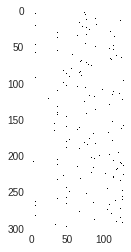

In [0]:
plt.imshow(lmao[0][0][0, :, :, 0])

In [0]:
import skimage.io

In [0]:
skimage.io.imsave('lmao.png', lmao[0][0][0, :, :, 0])

/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:132: UserWarning: lmao.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [0]:
files.download('lmao.png')

## Training

start the training

In [0]:
train_gen = DataGenerator(train_train)

35146


In [0]:
test_gen = DataGenerator(train_test)

3906


In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
import keras.callbacks as KC

In [0]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [0]:
checkpt = KC.ModelCheckpoint('logs/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)

In [0]:
import multiprocessing

In [0]:
workers = multiprocessing.cpu_count()
workers

2

In [0]:
epoch = 0

In [0]:
hist = model.fit_generator(generator=train_gen, epochs=epoch+1, verbose=1,
                           callbacks=[checkpt], validation_data=test_gen,
                           shuffle=True, initial_epoch=epoch, workers=workers,
                           max_queue_size=100, use_multiprocessing=True)
epoch += 1
epoch

Epoch 2/2
35146/35146 [==============================] - 6593s 188ms/step - loss: 2.9821 - acc: 0.0814 - val_loss: 2.9974 - val_acc: 0.0748


2

In [0]:
hist

In [0]:
!ls -l logs

total 426352
-rw-r--r-- 1 root root 218290640 Dec 23 19:34 weights.01-2.99.hdf5
-rw-r--r-- 1 root root 218290640 Dec 23 21:31 weights.02-3.00.hdf5


In [0]:
model.save_weights('first.hdf5')

In [0]:
!ls -l

total 277584
-rw-r--r-- 1 root root      2631 Dec 23 16:14 adc.json
-rw-r--r-- 1 root root 218290056 Dec 23 16:15 first_weights.h5
drwxr-xr-x 2 root root      4096 Dec 23 21:31 logs
-rw-r--r-- 1 root root   2465632 Dec 23 16:38 model.png
drwxr-xr-x 1 root root      4096 Dec 18 20:29 sample_data
-rw-r--r-- 1 root root    569537 Dec 23 16:11 sample_submission.csv.zip
---------- 1 root root  26957509 Dec 13 17:27 test.csv
-rw-r--r-- 1 root root  16987515 Dec 23 16:11 test.csv.zip
---------- 1 root root  11635300 Dec 13 17:27 train.csv
-rw-r--r-- 1 root root   7314592 Dec 23 16:11 train.csv.zip


In [0]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [0]:
# Upload the file to Drive. See:
#
# https://developers.google.com/drive/v3/reference/files/create
# https://developers.google.com/drive/v3/web/manage-uploads
from googleapiclient.http import MediaFileUpload

file_metadata = {
  'name': 'newsgroup_2.h5',
  'mimeType': 'application/x-hdf5'
}
media = MediaFileUpload('logs/weights.02-3.00.hdf5', 
                        mimetype='application/x-hdf5',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1AX1ohUoMWym3WMJQTUSrDINgcSNjivrv


In [0]:
from keras.utils import plot_model

In [0]:
plot_model(model, to_file='model.png')

In [0]:
from google.colab import files

In [0]:
files.download('model.png')

In [0]:
inception_model_thing = model.get_layer('inception_resnet_v2')

In [0]:
inception_model_thing.summary()

In [0]:
plot_model(inception_model_thing, to_file='model.png')

In [0]:
import h5py

In [0]:
with h5py.File('logs/weights.02-3.00.hdf5', 'r') as f:
    print(list(f.keys()))

['concat0', 'dense0', 'drop0', 'drop1', 'inception_resnet_v2', 'input_diff', 'input_tensor', 'predictions', 'triple_tensor']


In [0]:
with h5py.File('logs/weights.02-3.00.hdf5', 'r') as f:
    #for x, y in f['predictions'].items():
    #  print(x)
    #  print(y)
    for x, y in f['predictions']['predictions'].items():
      print(x)
      print(y)

bias:0
<HDF5 dataset "bias:0": shape (20,), type "<f4">
kernel:0
<HDF5 dataset "kernel:0": shape (20, 20), type "<f4">


sanity check

In [0]:
class DataGenerator(keras.utils.Sequence):

  def __init__(self, df):
    
    self.length = len(df.index)
    print(self.length)

    self.ciphertexts = self._transform_ciphers(df['ciphertext'])
    
    self.difficulties =  pd.get_dummies(df['difficulty'], dtype='float32').values
    
    self.labels = pd.get_dummies(df['target'], dtype='float32').values
    
    #self.X = np.empty((1, 300, 128, 1), dtype='float32')
    self.m_arange = np.arange(300)
  
  def _transform_ciphers(self, series):
    
    #print(series.shape)
    np_inputs = np.zeros((self.length, 300), dtype=np.byte)
    #for i, e in series.iteritems():
    i=0
    for _, e in series.iteritems():

      encoded = e.encode("ascii", errors='strict')
      np_enc = np.frombuffer(encoded, dtype=np.byte)
      how_big = np_enc.shape[0]
      np_inputs[i, :how_big] = np_enc
      
      i+=1
      
    return np_inputs

  def __len__(self):
    
    return 1
    #return self.length

  def __getitem__(self, index):
    
    #self.X[...] = 0
    #print(self.m_arange)
    X = np.zeros((1, 300, 128, 1), dtype='float32')
    X[0, self.m_arange, self.ciphertexts[index], 0] = 1
    return ([X, self.difficulties[index][np.newaxis]],
            self.labels[index][np.newaxis])

In [0]:
!mkdir test

In [0]:
model.save_weights('test/foo0.h5')

In [0]:
model.get_layer('inception_resnet_v2').summary()

In [0]:
model.load_weights('test/foo0.h5')

In [0]:
train_gen = DataGenerator(train_train)
test_gen = DataGenerator(train_test)

35146
3906


In [0]:
import keras.callbacks as KC

In [0]:
checkpt = KC.ModelCheckpoint('test/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)

In [0]:
hist = model.fit_generator(generator=train_gen, epochs=1, verbose=1,
                           callbacks=[checkpt], validation_data=test_gen,
                           shuffle=True, initial_epoch=0, workers=2,
                           max_queue_size=100, use_multiprocessing=True)

Epoch 1/1
1/1 [==============================] - 46s 46s/step - loss: 2.8252 - acc: 0.0000e+00 - val_loss: 16.1181 - val_acc: 0.0000e+00


In [0]:
!ls -l test

total 426356
-rw-r--r-- 1 root root 218289472 Dec 23 22:05 foo0.h5
-rw-r--r-- 1 root root 218289472 Dec 23 22:10 weights.01-16.12.hdf5


In [0]:
model.load_weights('test/weights.01-16.12.hdf5')

## Bleh bleh bleh

I couldn't find a name for this. I decided in the end maybe it would be better for some triplet loss/network and use inception for feature extraction.

In [0]:
import pandas as pd
import numpy as np

In [0]:
train = pd.read_csv('train.csv')

In [0]:
lmao = train.groupby('target')

In [0]:
type(lmao)

In [0]:
train.head()

In [0]:
lmao = train.loc[train['target'] == 0]

In [0]:
lmao.head()

In [0]:
lmao.shape

(1734, 4)

In [0]:
diff1 = train.loc[train['difficulty'] == 1]
diff2 = train.loc[train['difficulty'] == 2]
diff3 = train.loc[train['difficulty'] == 3]
diff4 = train.loc[train['difficulty'] == 4]

print(diff1.shape)
print(diff2.shape)
print(diff3.shape)
print(diff4.shape)

(9589, 4)
(10024, 4)
(9469, 4)
(9970, 4)


In [0]:
group_it = [diff1[diff1['target']==i] for i in range(0, 20)]

In [0]:
length_it = [len(e.index) for e in group_it]

In [0]:
length_it

[420,
 465,
 360,
 346,
 320,
 466,
 361,
 331,
 380,
 486,
 540,
 563,
 344,
 482,
 576,
 765,
 471,
 834,
 675,
 404]

In [0]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
import keras.layers as KL

Using TensorFlow backend.


In [0]:
input_x = KL.Input((300,128,1), name='input_x')
triple_x = KL.Concatenate(name='triple_x')([input_x, input_x, input_x])

input_y = KL.Input((300,128,1), name='input_y')
triple_y = KL.Concatenate(name='triple_y')([input_y, input_y, input_y])

In [0]:
inception_model = InceptionResNetV2(include_top=False,
                      weights='imagenet',
                      input_tensor=None,
                      input_shape=(300, 128, 3),
                      pooling=None)#'avg',
                      #classes=20)

In [0]:
layer_name = 'mixed_6a'
ir_sub_model = Model(inputs=inception_model.input,
                                 outputs=inception_model.get_layer(layer_name).output)

In [0]:
x_tensor = ir_sub_model(triple_x)
y_tensor = ir_sub_model(triple_y)

In [0]:
x_pool = KL.GlobalMaxPooling2D()(x_tensor)
y_pool = KL.GlobalMaxPooling2D()(y_tensor)

In [0]:
output = KL.Dot(axes=-1, normalize=True)([x_pool, y_pool])

In [0]:
the_model = Model(inputs=[input_x, input_y], outputs=output)

In [0]:
let_x = np.zeros((1, 300,128,1))
let_y = np.ones((1, 300,128,1))

In [0]:
lol = the_model.predict([let_x, let_y])

In [0]:
lol

array([[0.9655765]], dtype=float32)

avg pooling

In [0]:
x_pool = KL.GlobalAveragePooling2D()(x_tensor)
y_pool = KL.GlobalAveragePooling2D()(y_tensor)

In [0]:
lol

array([[0.96673405]], dtype=float32)

the other option

In [0]:
inception_model = InceptionResNetV2(include_top=False,
                      weights='imagenet',
                      input_tensor=None,
                      input_shape=(300, 128, 3),
                      pooling='max')

In [0]:
x_tensor = inception_model(triple_x)
y_tensor = inception_model(triple_y)

In [0]:
output = KL.Dot(axes=-1, normalize=True)([x_tensor, y_tensor])

In [0]:
the_model = Model(inputs=[input_x, input_y], outputs=output)

In [0]:
let_x = np.zeros((1, 300,128,1))
let_y = np.ones((1, 300,128,1))
lol = the_model.predict([let_x, let_y])

max pool

In [0]:
lol

array([[0.6128756]], dtype=float32)

avg pool

In [0]:
inception_model = InceptionResNetV2(include_top=False,
                      weights='imagenet',
                      input_tensor=None,
                      input_shape=(300, 128, 3),
                      pooling='avg')

In [0]:
lol

array([[0.7424079]], dtype=float32)

in conclusion, maybe it is best to use all of inception and train something like what the facenet researchers proposed

but it is important to note just a black and white image probably is not representative of the dataset.

## Cosine similarity

Now I will attempt to pick my triplets using pure cosine similarity.

http://www.cs.trincoll.edu/~crypto/resources/LetFreq.html

4.5 characters on average per English word

https://quotabulary.com/short-meaningful-quotes

suppose shortest sentence identifiable from a source such as a quote, is 10 words.

Then 10 times 4.5 is 45. Filter from here

In [0]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
import keras.layers as KL

Using TensorFlow backend.


In [0]:
input_x = KL.Input((300,))
input_y = KL.Input((300,))

In [0]:
output = KL.Dot(axes=-1, normalize=True)([input_x, input_y])

In [0]:
cosine_sim = Model(inputs=[input_x, input_y], outputs=output)

In [0]:
import numpy as np
import pandas as pd

In [0]:
train = pd.read_csv('train.csv')

In [0]:
print(len(train.index))

39052


In [0]:
filtered = train[train['ciphertext'].str.len() >= 45]

In [0]:
print(len(filtered.index))

38219


In [0]:
lol = train['ciphertext'].str.len()

In [0]:
type(lol)

pandas.core.series.Series

In [0]:
lol.describe()

count    39052.000000
mean       278.483356
std         61.807633
min          2.000000
25%        300.000000
50%        300.000000
75%        300.000000
max        300.000000
Name: ciphertext, dtype: float64

In [0]:
lol = filtered['ciphertext'].str.len()

In [0]:
lol.describe()

count    38219.000000
mean       284.033517
std         49.559244
min         45.000000
25%        300.000000
50%        300.000000
75%        300.000000
max        300.000000
Name: ciphertext, dtype: float64

forgot to use filtered, everything after is from train

In [0]:
diff1 = train.loc[train['difficulty'] == 1]

In [0]:
group_it = [diff1[diff1['target']==i] for i in range(0, 20)]

In [0]:
length_it = [[i, len(e.index)] for i, e in enumerate(group_it)]

In [0]:
length_it

[[0, 420],
 [1, 465],
 [2, 360],
 [3, 346],
 [4, 320],
 [5, 466],
 [6, 361],
 [7, 331],
 [8, 380],
 [9, 486],
 [10, 540],
 [11, 563],
 [12, 344],
 [13, 482],
 [14, 576],
 [15, 765],
 [16, 471],
 [17, 834],
 [18, 675],
 [19, 404]]

In [0]:
l = len(length_it)

In [0]:
import random

In [0]:
r = random.seed(a=42)

In [0]:
np.random.seed(42)

In [0]:
def get_it(size):
  
  x = np.arange(size)
  np.random.shuffle(x)
  return x

In [0]:
random_it = [get_it(how_long) for _,how_long in length_it]

In [0]:
for e in random_it:
  print(e[:5])

[145 334 175 369 416]
[ 70 233 215 247  39]
[323 200   8  11  47]
[337 308 269  94 105]
[ 51 108  42  68  12]
[ 86 255 102 154  93]
[183 259 161 360 211]
[252 259 194  70 260]
[210  51 218 284 159]
[329 149 436 124 479]
[400 310  63 267 285]
[390 247 444 475 395]
[160 262 290 135 242]
[221 248 300 390 478]
[251 161 446 129 137]
[234 185 166 681 573]
[410 239 327 139 406]
[239 218 647 320 249]
[458 278 369 153 321]
[220 402 277  73  75]


In [0]:
for e in random_it:
  print(e[-5:])

[ 71 106 270 348 102]
[289 238   0 121  57]
[263 358  33 110 227]
[292 260  19 118 194]
[221  59 223 232  73]
[403 444 250 107 389]
[220 307 358 100 272]
[315 173 181 296 325]
[307 375 160 319 264]
[188 430  12 324 442]
[108 402 281  98 255]
[353 448 174 329 194]
[263 327 173 278 108]
[229 457 285 463 312]
[380 268  45 420 562]
[199 190 668 620 326]
[188 143 122 150 460]
[394 556 656 550 710]
[100 566 102 258 436]
[219 339 119 271 237]


In [0]:
into_x = np.empty((1, 300,))
into_y = np.empty((1, 300,))

In [0]:
def encode_it(thingy, into):
  into[0, :] = 0
  encoded = thingy.encode("ascii", errors='strict')
  np_enc = np.frombuffer(encoded, dtype=np.byte)
  how_big = np_enc.shape[0]
  into[0, :how_big] = np_enc

In [0]:
test = 0

In [0]:
coords = []
similarities = []

In [0]:
while l > 1 and test < 100:
  
  index = random.randint(0, l-1)
  first = length_it.pop(index)
  
  index = random.randint(0, l-2)
  second = length_it[index]
  
  first[1] -= 1
  if first[1] > 0:
    
    length_it.append(first)

  second[1] -= 1
  if second[1] <= 0:

    length_it.pop(index)
    
  l = len(length_it)
  
  f_g = group_it[first[0]]
  s_g = group_it[second[0]]
  f_r = random_it[first[0]][first[1]]
  s_r = random_it[second[0]][second[1]]
  #print(f_g0)
  #print(s_g0)
  #print(first)
  #print(second)
  #print(f_r1)
  #print(s_r1)
  encode_it(f_g.iloc[f_r]['ciphertext'], into_x)
  encode_it(s_g.iloc[s_r]['ciphertext'], into_y)
  
  coords.append((first[0], f_r, second[0], s_r))
  similarities.append(cosine_sim.predict([into_x, into_y])[0,0])
  
  test += 1

In [0]:
for i in range(0,100):
  
  print("%s, %s" % (coords[i], similarities[i]))

(3, 194, 0, 102), 0.7662526
(9, 442, 8, 264), 0.62601525
(8, 319, 5, 389), 0.7686665
(4, 73, 9, 324), 0.08543558
(2, 227, 4, 232), 0.48469144
(18, 436, 1, 57), 0.33326927
(0, 348, 6, 272), 0.66434866
(12, 108, 14, 562), 0.7795819
(2, 110, 1, 121), 0.7212343
(0, 270, 13, 312), 0.53060853
(12, 278, 9, 12), 0.80190545
(14, 420, 4, 223), 0.76082385
(12, 173, 16, 460), 0.65111053
(1, 0, 13, 463), 0.53526306
(4, 59, 3, 118), 0.62594545
(17, 710, 11, 194), 0.79993343
(15, 326, 8, 160), 0.09485227
(10, 255, 7, 325), 0.8360181
(0, 106, 11, 329), 0.77451736
(2, 33, 14, 45), 0.7530693
(2, 358, 9, 430), 0.7875346
(6, 100, 17, 550), 0.78413594
(0, 71, 13, 285), 0.76676065
(1, 238, 11, 174), 0.574177
(6, 358, 18, 258), 0.7864833
(6, 307, 12, 327), 0.7118447
(1, 289, 3, 19), 0.7795684
(11, 448, 7, 296), 0.19615862
(8, 375, 12, 263), 0.79309726
(13, 457, 14, 268), 0.2837851
(19, 237, 2, 263), 0.7753915
(4, 221, 1, 95), 0.7527323
(2, 235, 18, 102), 0.7911516
(0, 188, 6, 220), 0.69181716
(14, 380, 15, 6

In [0]:
length_it

In [0]:
f_g0.shape

(346, 4)

In [0]:
f_g0.iloc[f_r1]

Id                                                 ID_0b28834b0
difficulty                                                    1
ciphertext    ^c1f^W1W0a_01A1'a1LrH1O#1^1^#1'avs1u<1r...
target                                                        3
Name: 22287, dtype: object

In [0]:
into_x.shape

(300,)

In [0]:
into_y.shape

(300,)

(4, 73, 9, 324), 0.08543558

In [0]:
group_it[4].iloc[73]['ciphertext']

"\x1b#\x1b1a\x02_^-'Ota\x03O\x038\x1b\x08\x08\x0811}cvt1t0^cd0t1'\x1b^'8\x1b1-ad0ts1[1WO\x02t1t^1f\x02^W\x08\x08\x08\x08\x08s1s1{0\x1b#\x1b;v1O\x03v^8ct\x1b8o1\x02^1#\x1bOv^\x021W0o1Aa]]\x1b#\x1b\x02_\x1bv1a\x021t0\x1b1x\x1e/e1O__\x1bvv1ta-\x1b1s1)O8^\x02\x1b)1W^c8A1_Ocv\x1b1O\x021a\x02_^-'Ota\x03a8ato\x0811{0\x1b#\x1b1W^c8A10Oz\x1b1t^1\x03\x1b1O\x02^t0\x1b#1s1Aa]]\x1b#\x1b\x02_\x1b1\x03\x1btW\x1b\x1b\x021t0\x1b1>:eev1]^#1t0\x1b#\x1b1t^1\x03\x1b1O1'#^\x038\x1b-\x0811:;z\x1b1^]t\x1b\x021cv\x1bA1s1-\x1b-^#o1"

In [0]:
group_it[9].iloc[324]['ciphertext']

'^O#\x08\x08\x08s'

(10, 108, 11, 204), 0.84277266

In [0]:
group_it[10].iloc[108]['ciphertext']

'*#^-G1-Oo\x02O#Ab#O-v\x1bo\x08_v\x088Oc#\x1b\x02taO\x02\x08_O1|\x1e^d\x1b#1eOo\x02O#Ays1>c\x03X\x1b_tG1\x1e\x1bG1Aaz\x081O\x02A1_^\x02]\x081\x02O-\x1bvs1%#dO\x02ahOta^\x02G1x\x1b\'t\x081^]12^-\'ct\x1b#1>_a\x1b\x02_\x1bT1FOc#\x1b\x02taO\x021@\x02az\x1b#vatoT1>cA\x03c#oT1%\x7fs1xavt#a\x03cta^\x02G1\x02Os1Fa\x02\x1bvG15us1s1:\x021 2\t\'x":\x08F}Fb\x02\x1bWv\x08_v^\x08cac_\x08\x1bAc[1\x1b\'#at_0Obv\x08\'vo_0\x08cac_\x08\x1bAc1|1EzO\x0219#at_0O#Ay1W#at\x1bvGs1s1[Q:1t0a\x02f1t0O'

In [0]:
group_it[11].iloc[204]['ciphertext']

'3L\\\\LL\\LLs1xJ111L\\\\L\\\\LLJ1113L\\\\LLL\\\\s1xJ111L\\\\LLL\\LJ1113L\\\\LLL\\Ls1xJ111L\\\\LLLL\\J1113L\\\\LLLL\\s1xJ111L\\\\LLLLLJ1113L\\\\LLLLLs1xJ111L\\L\\\\\\\\\\J1113L\\L\\\\\\\\\\s1xJ111L\\L\\\\\\\\LJ1113L\\L\\\\\\\\Ls1xJ111L\\L\\\\\\L\\J1113L\\L\\\\\\L\\s1xJ111L\\L\\LL\\\\J1113L\\L\\\\\\LLs1xJ111L\\L\\\\L\\\\J1113L\\L\\\\L\\\\s1xJ111L\\L\\\\L\\LJ1113L\\L\\\\L\\Ls1xJ111L\\L\\'

In [0]:
group_it[11].iloc[204]['ciphertext'][2]

'\\'